## Cleaning the Weekly Rental Data

In [303]:
import pandas as pd
import os, re

In [304]:
pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20

### Download Data

In [305]:
# set download path
data_path = "../data/raw/domain/"

# list csv files, make sure they match
csv_files = [file for file in os.listdir(data_path) if re.match(r'rental_listings_\d{4}_\d{2}.csv', file)]

In [306]:
# list of dataframes 
df_list = []

# read each file, extract year and month from filename, add as columns
for file in csv_files:
    match = re.search(r'rental_listings_(\d{4})_(\d{2}).csv', file)
    if match:
        year = match.group(1)
        quarter = match.group(2)
        df = pd.read_csv(os.path.join(data_path, file))
        df['year'] = year
        df['quarter'] = quarter
        df_list.append(df)

# concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

In [307]:
print(df.iloc[-1])

property_id                                                   17537987.0
url                           /5-40-sandwych-wentworth-nsw-2648-17537987
rental_price                                               $320 per week
bedrooms                                                             2.0
bathrooms                                                            1.0
car_spaces                                                           1.0
property_type                                    Apartment / Unit / Flat
land_area                                                            0.0
property_features                                             2, ,1, ,1,
suburb                                                         WENTWORTH
postcode                                                            2648
scraped_date                                         2025-04-25 21:10:55
wayback_url            https://web.archive.org/web/20250425211055/htt...
wayback_time                                       

In [308]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 31268, Columns: 52


In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

### Column Standardisation

Let's begin by standardising the columns

This will include: 

- checking for inconsistent column names across files
- rename columns to snake_case
- drop irrelevant columns

In [310]:
# standardise column names to snake_case
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

In [312]:
# only keep relevant columns
relevant_columns = [
    'rental_price', 'bedrooms', 'bathrooms', 'car_spaces',
    'property_type', 'land_area', 'property_features', 
    'suburb', 'postcode', 'year', 'quarter',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'agency_name', 'agent_name', 'appointment_only', 'avg_days_on_market',
    'description', 'family_percentage', 'features_list', 
    'first_listed_date', 'full_address', 'last_sold_date',
    'latitude', 'longitude', 'listing_status', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold',
    'renter_percentage', 'schools', 'single_percentage',
    'state_abbreviation', 'structured_features', 'unit_number', 'updated_date',
    'url'
]

df = df[relevant_columns]

In [313]:
df['state_abbreviation'].value_counts()

state_abbreviation
vic    14143
Name: count, dtype: int64

## Dealing with Missing Values

Let's first inspect the missing values to see if there are any trends

In [314]:
df.isna().sum()

rental_price               3
bedrooms                 324
bathrooms              14201
car_spaces              2112
property_type              3
land_area              14146
property_features         28
suburb                     0
postcode                   0
year                       0
quarter                    0
age_0_to_19            17125
age_20_to_39           17125
age_40_to_59           17125
age_60_plus            17125
agency_name            17125
agent_name             17396
appointment_only       17516
avg_days_on_market     17126
description            17127
family_percentage      17125
features_list          23274
first_listed_date      17125
full_address           17125
last_sold_date         28958
latitude               17125
longitude              17125
listing_status         17125
long_term_resident     17125
median_rent_price      17126
median_sold_price      17126
number_sold            17125
renter_percentage      17125
schools                17125
single_percent

First of all, having rental_price is essential; drop the records without this value

In [315]:
# drop rows where rental_price is missing
df = df.dropna(subset=['rental_price'])

### Clean and Convert Key Fields

We need to clean and convert columns to be more standardised and easier to analyse

Let's start with the rental_price.



First, let's remove '$' and ',' from the values

In [316]:
# remove '$' and ',' from rental_price 
df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_899/641504744.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)


Convert to lower casing to remove some duplicates

In [317]:
df["rental_price"] = df["rental_price"].str.lower()

There are a number of values in which we do not want

In [318]:
# remove spaces in rental_price
df['rental_price'] = df['rental_price'].str.replace(' ', '')

In [319]:
# keep records which start with a number
df = df[df['rental_price'].str.match(r'^\d')]

In [320]:
print(df['rental_price'].value_counts().sort_values())

rental_price
580p/w-ground-floorapartment                      1
450pw/avail.7.04.25                               1
760perweek|3302pcm                                1
730unlimitedwifiand1monthfreerent                 1
495p/winclgas&water                               1
600.00pw                                          1
830.00pw                                          1
525.00pw                                          1
905.00                                            1
535weekly                                         1
495perweekfurnished                               1
845.00perweek                                     1
530perweekincl.gaswater&internet                  1
699perweekincludingallutilities                   1
780pw                                             1
1270                                              1
3450perweek                                       1
980pw                                             1
520-perweek-fullyfurnished                        1

In [321]:
# extract numeric value from rental_price (based on the first number found)
df['price_value'] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

We also need a column to see if the rent is by weekly or monthly payments

In [322]:
freq_keywords = [
    'pw', 'perweek', 'weekly', 'p/w', 'wk', 'p.w.',
    '/wk', '/w', '/week', 'p.w',
    'permonth', 'pm', 'calendar', 'monthly', 'calender',
    'percalendarmonth', 'percalendermonth'
    ]

In [323]:
# Extract frequency keyword after the number
df["price_frequency"] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)+(" + "|".join(freq_keywords) + ")", expand=False)[1]

In [324]:
# Map known patterns to standardized categories
df["price_frequency"] = df["price_frequency"].map({
    "pw": "weekly",
    "p.w.": "weekly",
    "perweek": "weekly",
    "weekly": "weekly",
    "p/w": "weekly",
    "wk": "weekly",
    "p.w": "weekly",
    "/wk": "weekly",
    "/w": "weekly",
    "/week": "weekly",
    "pm": "monthly",
    "permonth": "monthly",
    "calendar": "monthly",
    "calender": "monthly",
    "monthly": "monthly",
    "percalendarmonth": "monthly",
    "percalendermonth": "monthly"
})

In [325]:
# If price is purely numeric (digits and full stops), assume weekly
numeric_mask = df["rental_price"].str.match(r"^[\d\.]+$")
df.loc[numeric_mask & df["price_frequency"].isna(), "price_frequency"] = "weekly"

# Assign 'unknown' to unmatched entries
df["price_frequency"] = df["price_frequency"].fillna("unknown")

# Convert to categorical type
df["price_frequency"] = pd.Categorical(df["price_frequency"], categories=["weekly", "monthly", "unknown"])

In [326]:
df['price_frequency'].value_counts()

price_frequency
weekly     30523
unknown       90
monthly       77
Name: count, dtype: int64

In [327]:
df[df['price_frequency'] == 'unknown']['rental_price'].value_counts().sort_values()

rental_price
470/2042                                 1
1weekrentonowner                         1
620fullyfurnished                        1
460-fullyfurnished                       1
780-fullyfurnished                       1
350-fullyfurnished                       1
350/1521                                 1
650aweekgardening&wifiincluded           1
395/-perweek                             1
370/1608pcm                              1
50perhour                                1
250pernight-4people                      1
600onhold                                1
435to450                                 1
500-fullyfurnished                       1
415/1803                                 1
630andfullyfurnishedoptionatextrapw      1
600furnished                             1
650-900                                  1
650underapplication                      1
850partlyfurnished                       1
430week|1864p.c.m|waterbillsincluded!    1
170to240                                 

In [328]:
# drop unknown price_frequency
df = df[df['price_frequency'] != 'unknown']

Now that we have a column for the actual price and a column for frequency, let's now calculate the weekly price and replace the rental price with that

In [329]:
# Create weekly_price based on price_frequency
df["weekly_price"] = df.apply(
    lambda row: row["price_value"] if row["price_frequency"] == "weekly"
    else row["price_value"] / 4 if row["price_frequency"] == "monthly"
    else None,
    axis=1
)

# Drop original columns
df = df.drop(columns=["rental_price", "price_value", "price_frequency"])


In [330]:
df["weekly_price"].describe()

count     30600.000000
mean        673.173867
std        6759.874664
min          18.000000
25%         450.000000
50%         550.000000
75%         660.000000
max      808500.000000
Name: weekly_price, dtype: float64

Let's first deal with the outliers using IQR

In [331]:
import numpy as np
import math as m

# Removing the outliers
def removeOutliers(dataframe, columns):
    """
    Detects and treats outliers using IQR for multiple variables in a DataFrame.
    :param dataframe: The input DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param n: number of records in the dataframe
    :param factor: The IQR factor to use for detecting outliers
    :return: The processed DataFrame with outliers treated
    """

    # calculate the factor based on the number of records
    factor = m.sqrt(np.log(len(dataframe))) - 0.5

    # iterate through each column to treat outliers
    for col in columns:
        # calculate Q1, Q3, and IQR
        Q3 = np.quantile(dataframe[col], 0.75)
        Q1 = np.quantile(dataframe[col], 0.25)
        IQR = Q3 - Q1

        print("IQR value for column %s is: %s" % (col, IQR))

        # determine the lower and upper range for outliers
        lower_range = Q1 - factor * IQR
        upper_range = Q3 + factor * IQR
        
        # filter dataframe to keep only rows within the IQR range
        dataframe = dataframe[(dataframe[col] >= lower_range) & (dataframe[col] <= upper_range)]
        print("After treating outliers, shape of data is: ", dataframe.shape)
    
    return dataframe

In [332]:
df = removeOutliers(df, ['weekly_price'])

IQR value for column weekly_price is: 210.0
After treating outliers, shape of data is:  (29661, 40)


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

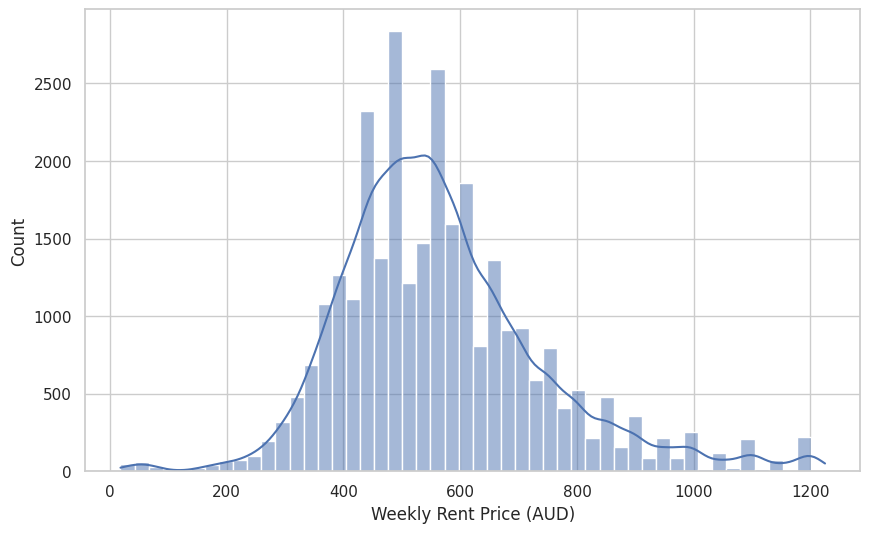

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["weekly_price"], bins=50, kde=True)

# Add labels and title
plt.xlabel("Weekly Rent Price (AUD)")
plt.ylabel("Count")
plt.title

## Cleaning Property Features

In order to answer question 2: Forecasting Rent Growth for suburbs, we need to match our scraped data's categories with provided ones from the ABS website.

The ABS dataset is aggregated by number of bedrooms and property type(1-3 for flats and 1-4 for houses), as well as a separate sheet for the grand total median over suburbs.

We will match that formatting with our scraped data by creating a new dataframe with each suburb as a record, and type of property + number of bedrooms for its columns. Each entry will be the median price of that combination.

### Number of Bedrooms

In [334]:
# find records where 'bedrooms' is missing and 'property_features' doesn't have digits
missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]

# drop rows where bedrooms is missing and 'property_features' doesn't have digits
df = df.drop(missing_bedrooms_features.index)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_899/3890117457.py:2: SyntaxWarning: invalid escape sequence '\d'
  missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]


In [335]:
# drop rows where property_features that do not start with a digit and bedrooms is missing
df_no_digit = df[df['property_features'].str.match(r'^\D', na=False)]
df_no_digit = df_no_digit[df_no_digit['bedrooms'].isnull()]
df = df.drop(df_no_digit.index)

In [336]:
# see if 'bedrooms' matches the first number in 'property_features'
bedroom_pattern = r'\b(\d+),'
df['extracted_bedrooms'] = df['property_features'].str.extract(bedroom_pattern, flags=re.IGNORECASE)[0].astype(float)

# remove records where 'bedrooms' is missing and 'extracted_bedrooms' is also missing
df = df[~(df['bedrooms'].isnull() & df['extracted_bedrooms'].isnull())]

# remove records where 'extracted_bedrooms' is missing
# all these records are acreage or land
df = df[~df['extracted_bedrooms'].isnull()]

In [338]:
# convert 'extracted_bedrooms' to int
df['extracted_bedrooms'] = df['extracted_bedrooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)

In [340]:
# how many records have mismatched bedrooms and extracted_bedrooms
df[df['bedrooms'] != df['extracted_bedrooms']].shape[0]

0

In [341]:
# fill missing bedrooms with extracted_bedrooms
df['bedrooms'].fillna(df['extracted_bedrooms'], inplace=True)

/tmp/ipykernel_899/1743008181.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bedrooms'].fillna(df['extracted_bedrooms'], inplace=True)


In [342]:
# how many records with missing bedrooms now
df['bedrooms'].isnull().sum()

np.int64(0)

### Property Type


# NOTE TO US!

Continue preprocessing here!

Let's have a look at listing status as well, as if they are active, it suggests that the price may not be desirable, therefore the property may not be rented out at this price.

In [32]:
# what values are in 'listing_status'?
df['listing_status'].value_counts()

listing_status
live               9274
recentlyUpdated    2387
new                1755
depositTaken         87
leased               18
Name: count, dtype: int64